In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgbm
import catboost

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e4/train.csv").drop(columns="id")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e4/test.csv")
orig_df = pd.read_csv("/kaggle/input/creditcard/creditcard.csv")
display(train_df)
display(test_df)
display(orig_df)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219124,120580.0,1.891079,-1.272908,-3.783908,-1.388939,2.012789,2.666080,0.151740,0.401934,-1.102824,...,-0.181369,-0.456538,-0.069571,0.756765,0.244479,-0.147566,-0.054725,-0.044588,198.65,0
219125,120580.0,0.139724,0.948649,-2.913655,-2.184829,1.883716,-1.056824,1.725624,0.018089,-0.823494,...,0.491469,1.478823,-0.085398,-0.091409,-1.053488,0.467570,0.358918,0.294735,24.00,0
219126,120580.0,2.058343,-0.038993,-1.928553,0.330117,0.270127,-0.735664,-0.173878,0.144823,0.849289,...,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,-0.098387,-0.044064,1.79,0
219127,120580.0,2.079227,-2.162389,-1.785833,-2.804889,0.552845,4.038013,-2.155900,1.023785,-0.865242,...,0.109909,0.590401,0.286621,0.675660,-0.510736,-0.090044,0.056749,-0.017126,88.00,0


,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,219129,120580.0,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,...,0.067367,0.241708,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944,29.95
1,219130,120580.0,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,...,0.441788,0.543278,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690,163.50
2,219131,120580.0,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,...,-0.366906,-0.131527,0.086623,0.291375,0.739087,-0.543006,-0.297813,0.043699,-0.037855,16.00
3,219132,120580.0,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,...,-0.049136,-0.080115,-0.010732,-0.038550,0.656830,0.343470,-0.627529,-0.024338,-0.036143,120.98
4,219133,120580.0,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,...,0.391627,0.083389,-0.306918,0.247822,-0.391799,-0.790716,-0.025706,0.330758,0.335537,1.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146082,365211,172789.0,-0.661834,-0.622980,0.735580,-0.554067,0.869889,-0.389502,0.161226,0.069945,...,0.262408,-0.046068,-0.425692,0.253833,-1.076331,-0.999877,0.161938,0.149243,0.279708,94.81
146083,365212,172789.0,-0.098889,0.761900,0.340012,-0.589546,0.717091,-0.262765,0.726272,-0.070608,...,0.064640,0.441215,1.284819,-0.141790,0.646930,-0.419964,-0.561426,0.326700,0.255166,24.99
146084,365213,172789.0,-1.487918,1.769142,0.551671,0.361566,0.056347,0.084844,0.567545,-0.059899,...,0.792736,0.163500,1.287079,-0.186955,-0.349847,-0.161724,-0.213933,0.392745,0.070938,29.99
146085,365214,172790.0,-1.889979,-0.154869,0.068496,-1.906964,-1.743181,0.717490,0.981608,-0.209713,...,-0.513829,0.121457,0.764642,-0.217844,0.104599,-0.008906,-0.204957,-0.752326,-0.155728,314.00


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train_df, title= "Profile Report of Train dataframe",minimal=True)
profile



Summarize dataset:   0%|          | 0/39 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
orig_df['Class'] = (orig_df['Class'] == 1).astype(np.int64)
orig_df = orig_df[list(train_df.columns)]
train_extended = pd.concat([train_df, orig_df]).reset_index(drop=True)

In [7]:
train_extended.drop(columns=["Time"], inplace=True)
test_df.drop(columns = ["Time"] , inplace = True)
train_extended.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


In [8]:
X_train = train_extended.drop("Class",axis = 1)
X_test = test_df.drop("id" , axis = 1)
y = train_extended.Class

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import optuna


In [11]:
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y, test_size=0.3, random_state=1)


In [12]:
model = XGBClassifier(use_label_encoder=False, 
                      eval_metric='auc')
model.fit(X_train1, y_train1)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [13]:
y_pred = model.predict_proba(X_val)[:, 1]

In [14]:
roc = roc_auc_score(y_val, y_pred)
roc

0.8541566947489039

In [16]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'auc',
        'nthread' : -1,
        'use_label_encoder': False
        
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train1, y_train1)

    # Make predictions
    y_pred = optuna_model.predict_proba(X_val)[:, 1]

    # Evaluate predictions
    roc = roc_auc_score(y_val, y_pred)
    return roc


In [18]:
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [19]:
study = optuna.create_study(direction='maximize',sampler=TPESampler())

[I 2023-01-24 07:24:23,935] A new study created in memory with name: no-name-ff306f8b-fd61-429f-b708-0a120d24958f


In [20]:
study.optimize(objective, n_trials=100, show_progress_bar = True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-01-24 07:24:43,337] Trial 0 finished with value: 0.8690671780364855 and parameters: {'max_depth': 6, 'learning_rate': 0.1053557626175942, 'n_estimators': 187, 'min_child_weight': 10, 'gamma': 1.9613595047669535e-05, 'subsample': 0.09955013170828417, 'colsample_bytree': 0.18768090609299504, 'reg_alpha': 0.0020621286511054763, 'reg_lambda': 0.0001029112251364925}. Best is trial 0 with value: 0.8690671780364855.
[I 2023-01-24 07:24:58,596] Trial 1 finished with value: 0.8191260691377227 and parameters: {'max_depth': 3, 'learning_rate': 0.40757114128088434, 'n_estimators': 248, 'min_child_weight': 7, 'gamma': 0.10597939710755712, 'subsample': 0.1499897891238415, 'colsample_bytree': 0.07803447550060112, 'reg_alpha': 0.012776030911310316, 'reg_lambda': 0.019291621460805725}. Best is trial 0 with value: 0.8690671780364855.
[I 2023-01-24 07:25:01,157] Trial 2 finished with value: 0.8347950765687464 and parameters: {'max_depth': 2, 'learning_rate': 0.1363757106027681, 'n_estimators': 50

In [21]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


Number of finished trials: 100
Best trial:
  Value: 0.888679753860918
  Params: 
    max_depth: 9
    learning_rate: 0.018582929582035137
    n_estimators: 484
    min_child_weight: 6
    gamma: 0.0024617748999073226
    subsample: 0.18395405424135147
    colsample_bytree: 0.3379155559338146
    reg_alpha: 7.637117204516838e-08
    reg_lambda: 2.6839785921698576e-08


In [23]:
params = trial.params

In [25]:
model = XGBClassifier(**params,eval_metric='auc')
model.fit(X_train, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3379155559338146,
              eval_metric='auc', gamma=0.0024617748999073226, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.018582929582035137, max_delta_step=0, max_depth=9,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=484, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=7.637117204516838e-08,
              reg_lambda=2.6839785921698576e-08, scale_pos_weight=1,
              subsample=0.18395405424135147, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [26]:
y_preds = model.predict_proba(X_test)[:, 1]

In [27]:
ss = pd.read_csv("/kaggle/input/playground-series-s3e4/sample_submission.csv", index_col=0)
ss['Class'] = y_preds
ss.to_csv("submission1.csv")
ss



,Class
id,
219129,0.000668
219130,0.000842
219131,0.000401
219132,0.000944
219133,0.000781
...,...
365211,0.000457
365212,0.000699
365213,0.001233


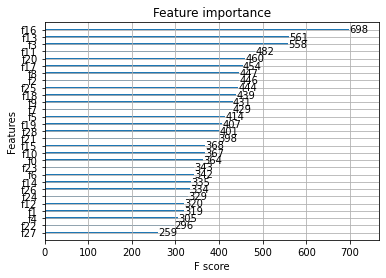

In [30]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
# plot feature importance
plot_importance(model)
plt.show()

In [45]:
import lightgbm as lgb
base_model = lgb.LGBMClassifier()
base_model.fit(X_train1, y_train1)

LGBMClassifier()

In [46]:
y_pred = model.predict_proba(X_val)[:, 1]


In [47]:
roc = roc_auc_score(y_val, y_pred)
roc

0.9417793079134638

In [48]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train1, y_train1)
    preds = gbm.predict_proba(X_val)[:, 1]
    roc = roc_auc_score(y_val, preds)
    return roc



In [49]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar = True)


[I 2023-01-24 09:31:07,530] A new study created in memory with name: lightgbm


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-01-24 09:31:09,976] Trial 0 finished with value: 0.8680209030270254 and parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 0 with value: 0.8680209030270254.
[LightGBM] [Warning] bagging_fraction is set=0.8111317002380557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8111317002380557
[LightGBM] [Warning] lambda_l2 is set=3.72312200494449e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.72312200494449e-05
[LightGBM] [Warning] lambda_l1 is set=1.2883876209377052e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2883876209377052e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6515167086419769, colsample_bytree=1.0 will be ignored. Current

In [50]:
print('Best parameters:', study.best_params)

Best parameters: {'lambda_l1': 2.2389697970671103e-05, 'lambda_l2': 3.0520336450984176, 'num_leaves': 8, 'feature_fraction': 0.8991025548488221, 'bagging_fraction': 0.8767607929561961, 'bagging_freq': 4, 'min_child_samples': 47}


In [51]:
modellgb = lgb.LGBMClassifier(**study.best_params)
modellgb.fit(X_train, y)


[LightGBM] [Warning] lambda_l1 is set=2.2389697970671103e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2389697970671103e-05
[LightGBM] [Warning] feature_fraction is set=0.8991025548488221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8991025548488221
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.0520336450984176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0520336450984176
[LightGBM] [Warning] bagging_fraction is set=0.8767607929561961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8767607929561961


LGBMClassifier(bagging_fraction=0.8767607929561961, bagging_freq=4,
               feature_fraction=0.8991025548488221,
               lambda_l1=2.2389697970671103e-05, lambda_l2=3.0520336450984176,
               min_child_samples=47, num_leaves=8)

In [53]:
y_preds1 = modellgb.predict_proba(X_test)[:, 1]

In [54]:
ss['Class'] = y_preds1
ss.to_csv("submission2.csv")
ss

,Class
id,
219129,0.000711
219130,0.000405
219131,0.000331
219132,0.000885
219133,0.000278
...,...
365211,0.000258
365212,0.000695
365213,0.000599
